In [1]:
# imports and loading
from pymodulon.io import *
from pymodulon.plotting import *
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # For treemap plotting
import sys
sys.path.insert(0, '../functions/matplotlib-extra-master/src')
import mpl_extra.treemap as tr

data_dir = path.join('..','data','processed_data')
interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))

QC_stats_df = pd.read_csv('../data/interim/metadata_qc_part2_all.tsv', delimiter = '\t')

In [11]:
QC_stats_df

,Unnamed: 0,BioProject,additional_details_2,sample_id,study,project,condition,rep_id,doi,gene_KO,...,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation,passed_curation,passed_replicate_correlations
0,SRX14570271,PRJNA818710,1162H3,NaN,ethanol_ferment_phenolic_stress,ethanol_ferment_phenolic_stress,ZM0116_H,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,True,False,True
1,SRX14570272,PRJNA818710,1162S1,NaN,ethanol_ferment_phenolic_stress,ethanol_ferment_phenolic_stress,ZM0116_S,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,True,False,True
2,SRX14570273,PRJNA818710,1162S2,NaN,ethanol_ferment_phenolic_stress,ethanol_ferment_phenolic_stress,ZM0116_S,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,True,False,True
3,SRX14570274,PRJNA818710,1162S3,NaN,ethanol_ferment_phenolic_stress,ethanol_ferment_phenolic_stress,ZM0116_S,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,True,False,True
4,SRX14570275,PRJNA818710,1162V1,NaN,ethanol_ferment_phenolic_stress,ethanol_ferment_phenolic_stress,ZM0116_V,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Kiley_B_WT_-O2_NoFe_DIP_A,NaN,NaN,NaN,stressors,stressors,WT_anaerobic_NoFe_DIP,1,NaN,NaN,...,private?,NaN,NaN,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,True,True,True,True,True
386,Kiley_B_WT_-O2_NoFe_DIP_B,NaN,NaN,NaN,stressors,stressors,WT_anaerobic_NoFe_DIP,2,NaN,NaN,...,private?,NaN,NaN,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,True,True,True,True,True
387,Kiley_B_WT_-O2_NoFe_DIP_C,NaN,NaN,NaN,stressors,stressors,WT_anaerobic_NoFe_DIP,3,NaN,NaN,...,private?,NaN,NaN,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,True,True,True,True,True
388,Kiley_B_WT_-O2_Peroxide_A,NaN,NaN,NaN,stressors,stressors,WT_anaerobic_Peroxide,1,NaN,NaN,...,private?,NaN,NaN,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,/home/glbrc.org/cdalldorf/iModulonMiner/data/r...,True,True,True,True,True


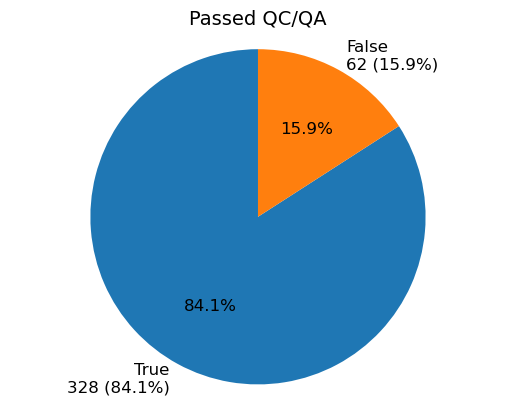

In [2]:
# let's create some summary tables, first pie chart of QC pass/fail
data = dict(QC_stats_df.passed_curation.value_counts())
total = sum(data.values())

# Calculate percentages
percentages = {key: (value / total) * 100 for key, value in data.items()}

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(
    data.values(),
    labels=[f"{key}\n{value} ({percentages[key]:.1f}%)" for key, value in data.items()],
    autopct='%.1f%%', 
    startangle=90, 
    textprops={'fontsize': 12}
)
ax.set_title('Passed QC/QA', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Display the chart
plt.show()

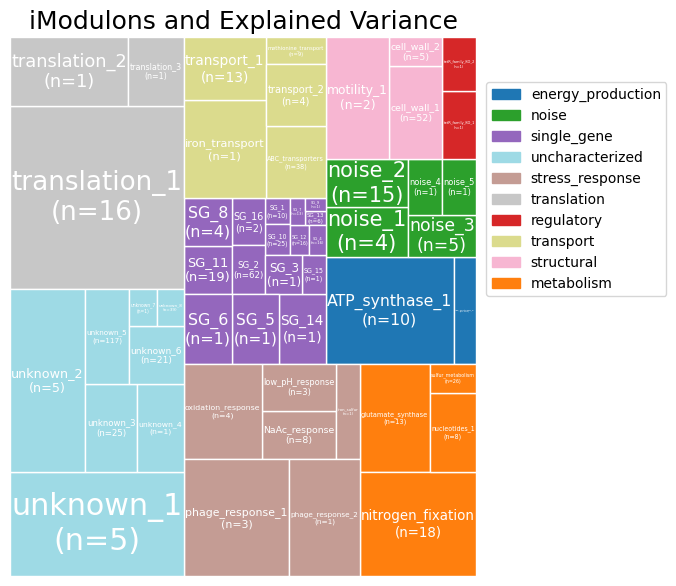

In [10]:
# explained variance treemap plot
df = ica_data.imodulon_table
df = df.sort_values(by = 'category')
df['labels'] = [index + '\n(n='+str(size)+')' for (index, size) in zip(df.index, ica_data.imodulon_table.imodulon_size)]

# Dynamically generate a color palette for unique categories
unique_categories = df['category'].unique()
palette = sns.color_palette('tab20', len(unique_categories))  # 'tab20' gives up to 20 distinct colors
color_map = dict(zip(unique_categories, palette))

# Map colors to categories
colors = df['category'].map(color_map)

# Create the treemap
fig, ax = plt.subplots(figsize=(7,7), dpi=100, subplot_kw=dict(aspect=1.156))
trc = tr.treemap(ax, df, area = 'explained_variance', labels = 'labels',
           cmap='tab20', fill='category', levels = ['category', 'labels'],
           rectprops=dict(ec='w'),
           textprops=dict(c='w'))

# make a legend
handles = sorted(trc.handles['labels'], 
                 key=lambda x: (x.get_ec(),x.get_label()))
legend = fig.legend(handles=[handles[i] for i in range(len(handles))],
          ncol=1, loc='lower left', bbox_to_anchor=(0.85, 0.5))

# Customize the plot
plt.title('iModulons and Explained Variance', fontsize=18)
plt.axis('off')  # Remove axes
plt.show()